# Imports

In [1]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 10.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import missingno as msno
import torchmetrics

# Step 1: Load and preprocess the Titanic dataset

In [62]:
# Load the Titanic dataset
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [63]:
# Drop unnecessary columns: 'deck', 'class', 'embark_town', 'who', 'alive'
titanic = titanic.drop(columns=['deck', 'class', 'embark_town', 'who', 'alive'])
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,True,False
1,1,1,female,38.0,1,0,71.2833,C,False,False
2,1,3,female,26.0,0,0,7.9250,S,False,True
3,1,1,female,35.0,1,0,53.1000,S,False,False
4,0,3,male,35.0,0,0,8.0500,S,True,True


(<Axes: >, 891)

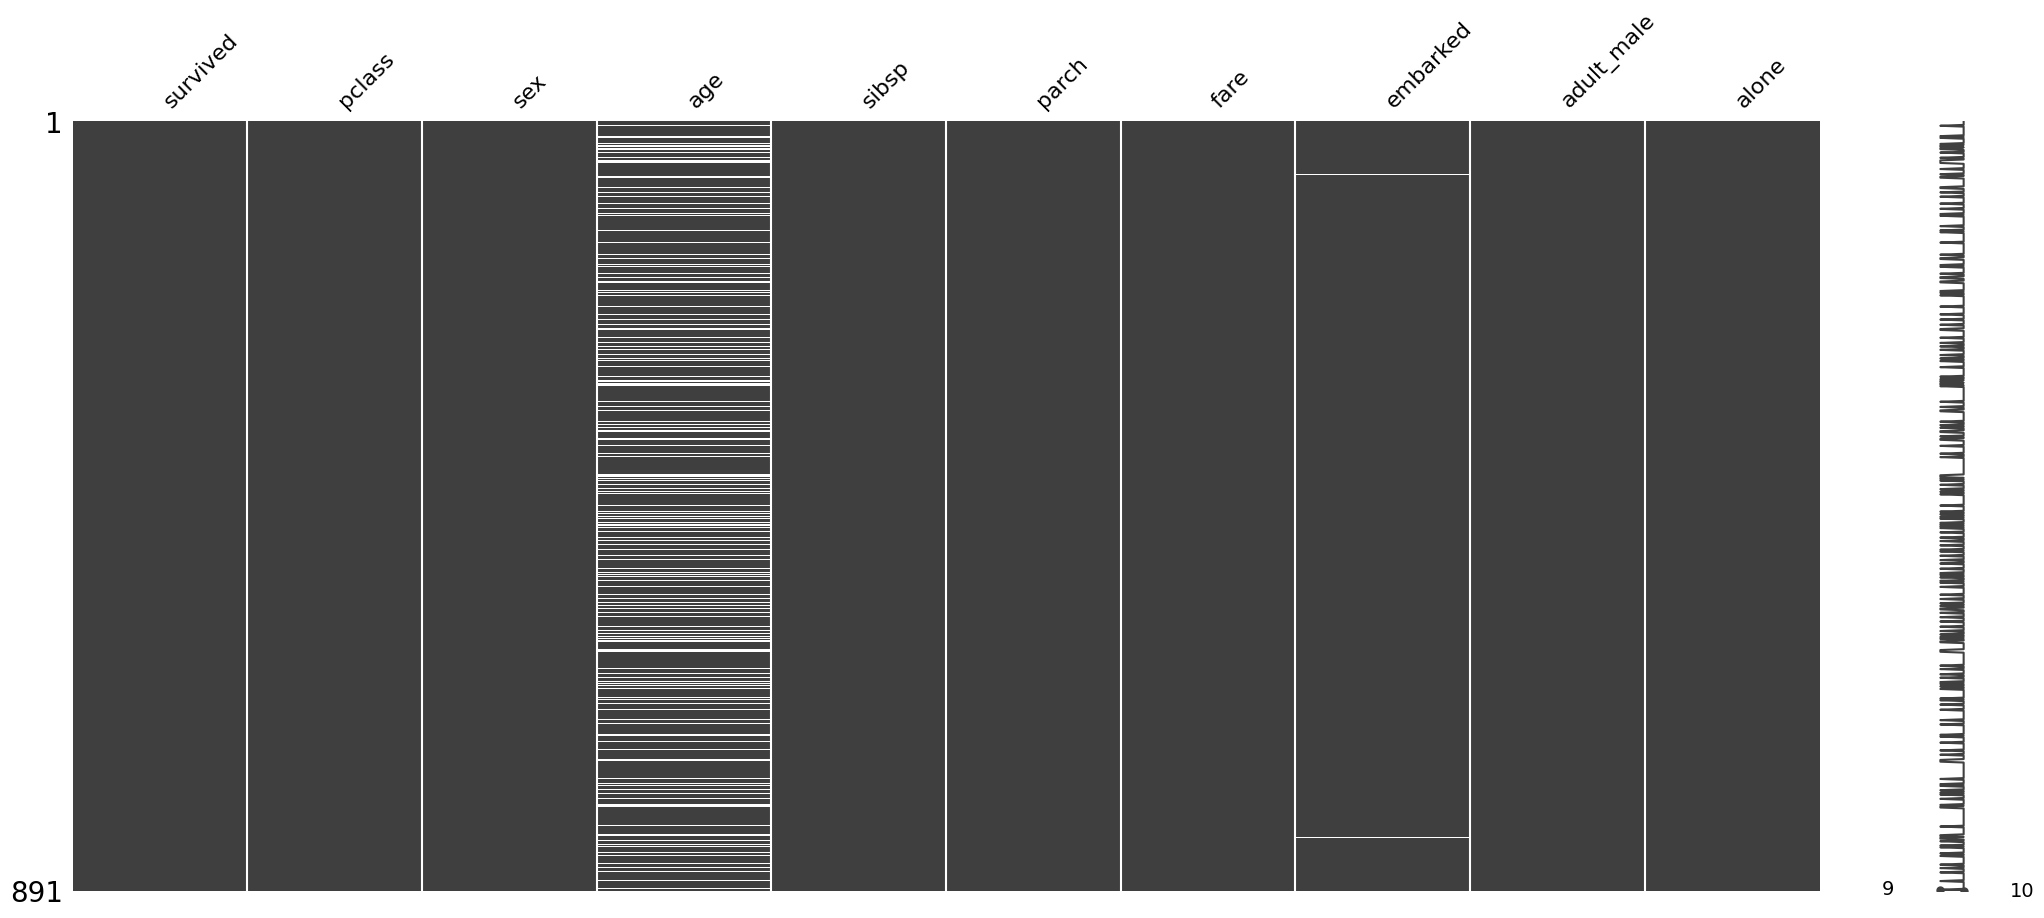

In [39]:
msno.matrix(titanic), len(titanic)

In [76]:
# Fill missing values
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
titanic.isnull().sum()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
adult_male    0
alone         0
dtype: int64

## 1. Missing Values

### Strategies for Handling Missing Values

#### 1. Imputation for age
We can implement several techniques to handle missing values in the age column.

- **a. Mean Imputation**:   
This fills missing values with the mean age of all passengers.

In [22]:
mean_age = titanic['age'].mean()
titanic['age'] = titanic['age'].fillna(mean_age)

- **b. Median Imputation**:  
This is a robust method, especially useful if your data is skewed.

In [23]:
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

- **c. Group-Based Median Imputation**:  
Filling missing 'age' values based on their passenger class (Pclass) median age:

In [24]:
titanic['age'] = titanic.groupby('pclass')['age'].transform(lambda x: x.fillna(x.median()))

- **d. Predictive Modeling**:  
Using models like KNN to predict ages based on other features, but this requires more setup and additional packages.   
Here’s a simplified example assuming the KNNImputer is used.

In [25]:
from sklearn.impute import KNNImputer
import pandas as pd


# Create a separate DataFrame without rows containing missing values in the features
complete_data = titanic[['age', 'pclass', 'fare']].dropna()

# Create the imputer and fit it on the complete data
imputer = KNNImputer(n_neighbors=5)
age_imputed = imputer.fit_transform(complete_data)

# Convert back to a DataFrame
imputed_df = pd.DataFrame(age_imputed, columns=['age', 'pclass', 'fare'])

# Now we need to update the original DataFrame's age column
# First, we will find the indices where age was missing
missing_age_indices = titanic[titanic['age'].isnull()].index

# Update the original DataFrame with the imputed values
for index, value in zip(missing_age_indices, imputed_df.loc[missing_age_indices].age):
    titanic.at[index, 'age'] = value

# Check the updated DataFrame
titanic.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
1,1,1,female,38.0,1,0,71.2833,C,False,False
3,1,1,female,35.0,1,0,53.1000,S,False,False


#### 2. Imputation for embarked  
Now, let's look at handling missing values in the embarked column.

- **a. Mode Imputation**:  
Filling missing values with the mode (most frequent category) of the embarked column.

In [26]:
mode_embarked = titanic['embarked'].mode()[0]
titanic['embarked'] = titanic['embarked'].fillna(mode_embarked)

- **b. Group-Based Mode Imputation**:  
Filling 'embarked' based on the mode of the passenger's class (Pclass):

In [27]:
titanic['embarked'] = titanic.groupby('pclass')['embarked'].transform(lambda x: x.fillna(x.mode()[0]))

#### 3. Removing rows with any missing values  


- **When to Remove Rows**
    1. **Small Amount of Missing Data**: If only a small percentage of the data is missing, it may be reasonable to remove those rows without introducing bias into the analysis.

    2. **Uninformative Missingness**: If the missing data is assumed to be missing completely at random (MCAR), removing these rows can be an acceptable solution.

    3. **Model Simplicity**: For simpler models, working with complete cases can simplify the modeling process because you avoid the complications that arise from imputing missing values.

- **Implications of Removing Rows**
    - **Loss of Data**: Each removed row represents a loss of potentially valuable information. If too many rows are removed, the analysis could become biased or lack statistical power.
    - **Data Distribution Changes**: The removal of rows can change the distribution of the data, which may have implications for further analysis.
    - **Loss of Insights**: If the missingness of data has significance, simply removing these rows can lead to the loss of potentially critical insights.


In [46]:
titanic = titanic.dropna()

#### 4. Verify Missing Values:  
To ensure all missing values are addressed, you can check the dataset for remaining null values:

In [29]:
titanic.isnull().sum()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
adult_male    0
alone         0
dtype: int64

## 2. Encoding Categorical Features in Titanic Dataset  
The Titanic dataset has categorical features like sex, embarked, and pclass that we need to transform into a numeric format for machine learning models. Below are three different encoding methods: Label Encoding, One-Hot Encoding, 

**When we use LabelEncoder, or Onehotencoder**
- **LabelEncoder**:
    - Ordinal categories: Low, Medium, High

- **One Hot encoder**:  
    - Nominal categories: colors, cities

### 2-1. Label Encoding
Label Encoding assigns a unique numerical value to each category in a feature.  
This is useful when the categorical feature has an implicit order, though it can introduce an artificial ordering for non-ordinal features.

In [30]:
titanic.select_dtypes('object')

,sex,embarked
1,female,C
3,female,S
6,male,S
10,female,S
11,female,S
...,...,...
871,female,S
872,male,S
879,female,C
887,female,S


In [32]:
from sklearn.preprocessing import LabelEncoder

df = titanic.copy()

# Initialize Label Encoder
le = LabelEncoder()

# Encode the 'sex' column
df['sex'] = le.fit_transform(df['sex'])
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
1,1,1,0,38.0,1,0,71.2833,C,False,False
3,1,1,0,35.0,1,0,53.1000,S,False,False
6,0,1,1,54.0,0,0,51.8625,S,True,True
10,1,3,0,4.0,1,1,16.7000,S,False,False
11,1,1,0,58.0,0,0,26.5500,S,False,True


### 2-2. One-Hot Encoding  
One-Hot Encoding creates a new binary column for each category in a feature.   
This method is widely used for non-ordinal categorical data and helps prevent the model from assuming any ordering among categories.

In [33]:
# One-Hot Encode 'embarked' column
import pandas as pd

df = pd.get_dummies(df, columns=['embarked'])
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,alone,embarked_C,embarked_Q,embarked_S
1,1,1,0,38.0,1,0,71.2833,False,False,True,False,False
3,1,1,0,35.0,1,0,53.1000,False,False,False,False,True
6,0,1,1,54.0,0,0,51.8625,True,True,False,False,True
10,1,3,0,4.0,1,1,16.7000,False,False,False,False,True
11,1,1,0,58.0,0,0,26.5500,False,True,False,False,True


### 2-2. One-Hot Encoding with sklearn OneHotEncoder


In [52]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse_output=False)

# df = titanic.copy()
titanic[['male', 'female']] = onehot.fit_transform(titanic[['sex']])
titanic[['S', 'C', 'Q']] = onehot.fit_transform(titanic[['embarked']])
titanic = titanic.drop(['sex', 'embarked'], axis=1)
titanic.head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,male,female,S,C,Q
0,0,3,22.0,1,0,7.2500,True,False,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,False,False,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,False,True,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,False,False,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,True,True,0.0,1.0,0.0,0.0,1.0


### 2-3. You can also use the below code

In [77]:
# Encode categorical features
le_sex = LabelEncoder()
le_embarked = LabelEncoder()

titanic['sex'] = le_sex.fit_transform(titanic['sex'])
titanic['embarked'] = le_embarked.fit_transform(titanic['embarked'])
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,1,22.0,1,0,7.2500,2,True,False
1,1,1,0,38.0,1,0,71.2833,0,False,False
2,1,3,0,26.0,0,0,7.9250,2,False,True
3,1,1,0,35.0,1,0,53.1000,2,False,False
4,0,3,1,35.0,0,0,8.0500,2,True,True


# Step 2: Define a custom Dataset class for PyTorch

In [49]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Define the MLP model

In [50]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Utils

## AverageMeter

In [51]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, value, n=1):
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

### How AverageMeter works

In [52]:
loss_meter = AverageMeter()

In [53]:
loss_meter.update(10)
loss_meter.update(20)
loss_meter.update(50)
loss_meter.update(11)
loss_meter.update(22)

In [54]:
loss_meter.sum, loss_meter.count, loss_meter.avg

(113, 5, 22.6)

In [55]:
loss_meter.reset()

## Set Seeds for Reproducibility

In [56]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    # np.random.seed(seed)
    # random.seed(seed)
    if torch.cuda.is_available():
        # Multi gpu
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)

set_seed(42)

# Step 5: Preprocessing for MLP

In [85]:
# Convert boolean columns to integers, if applicable  
X = titanic.drop(columns=['survived']).astype({'adult_male': 'int',
                                               'alone': 'int'}).values

y = titanic['survived'].values  # Target (survival label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Scaling Methods

### **1. Standard Scaling**    
Standard Scaling (or Z-score normalization) adjusts features to have a mean of 0 and a standard deviation of 1.   
This is often effective for models that assume features are normally distributed, such as linear models and neural networks.

![Standard Scaling](https://raw.githubusercontent.com/Ebimsv/Machine_Learning_Course/main/pics/Standard_Scaling.png)

where:
- 𝑋 is the original feature value,
- 𝜇 is the mean of the feature values,
- σ is the standard deviation of the feature values.

#### Method 1: Standard Scaling from Scratch

**Note**:  
- We calculate the mean and standard deviation **only on the training data** and use those values to transform both the training and validation sets.
- With sklearn, this is handled automatically by the **fit** and **transform** methods, so the process is straightforward.

In [89]:
import numpy as np

# Custom function to standardize features with training mean and std
def standardize_data(X, mean, std):
    return (X - mean) / std

# Calculate mean and std from the training set
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

# Standardize training and validation data using the training statistics
X_train_standardized = standardize_data(X_train, train_mean, train_std)
X_val_standardized = standardize_data(X_val, train_mean, train_std)

#### Method 2: Standard Scaling with sklearn

In [88]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and validation sets
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)

### **2. Normalization (Min-Max Scaling)**  
Normalization scales each feature to a specified range, typically [0, 1].   
This is useful for algorithms that are sensitive to feature ranges, such as neural networks and k-nearest neighbors.


![Normalization](https://raw.githubusercontent.com/Ebimsv/Machine_Learning_Course/main/pics/Normalization.png)

where:
- 𝑋 is the original feature value,
- 𝑋_min: is the minimum value of the feature,
- 𝑋_max​: is the maximum value of the feature.

#### Method 1: Normalization from Scratch

In [ ]:
# Custom function to normalize features with training min and max
def normalize_data(X, min_val, max_val):
    return (X - min_val) / (max_val - min_val)

# Calculate min and max from the training set
train_min = np.min(X_train, axis=0)
train_max = np.max(X_train, axis=0)

# Normalize training and validation data using the training statistics
X_train_normalized = normalize_data(X_train, train_min, train_max)
X_val_normalized = normalize_data(X_val, train_min, train_max)

#### Method 2: Normalization with sklearn

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler to scale data to [0, 1]
scaler = MinMaxScaler()

# Fit on training data and transform both training and validation sets
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)

## Convert to PyTorch datasets

In [ ]:
train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [64]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch

(torch.Size([64, 9]),
 tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 1., 0., 0., 0., 1., 0.]))

## How `BCEloss` , and `BCEWithLogitsLoss` work

In [65]:
import torch.nn as nn

sigmoid = nn.Sigmoid()
loss_fn = nn.BCELoss()

pred = torch.randn(3, 2, requires_grad=True, dtype=torch.float32)
target = torch.randint(0, 2, (3, 2), requires_grad=False, dtype=torch.float32)

pred, target

(tensor([[ 0.6688, -0.7077],
         [-0.3267, -0.2788],
         [-0.4220, -1.3323]], requires_grad=True),
 tensor([[0., 0.],
         [0., 0.],
         [1., 1.]]))

In [66]:
sigmoid(pred)

tensor([[0.6612, 0.3301],
        [0.4190, 0.4307],
        [0.3960, 0.2088]], grad_fn=<SigmoidBackward0>)

In [67]:
loss = loss_fn(sigmoid(pred), target)
loss

tensor(0.8471, grad_fn=<BinaryCrossEntropyBackward0>)

In [68]:
loss_fn = nn.BCEWithLogitsLoss()

loss = loss_fn(pred, target)
loss

tensor(0.8471, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Step 6: Initialize model, loss function, optimizer, and other components


In [69]:
input_size = X_train.shape[1]
output_size = 1  # Binary classification (survived or not)
hidden_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Step: Add weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Initialize model, and Apply the weight initialization
model = MLP(input_size, hidden_size, output_size).to(device)
model.apply(init_weights)

# TensorBoard writer
writer = SummaryWriter()

criterion = nn.BCEWithLogitsLoss()

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [70]:
# Print the model's parameters
for name, param in model.named_parameters():
    print(f'Parameter name: {name}, shape: {param.shape}')

Parameter name: fc1.weight, shape: torch.Size([128, 9])
Parameter name: fc1.bias, shape: torch.Size([128])
Parameter name: fc2.weight, shape: torch.Size([128, 128])
Parameter name: fc2.bias, shape: torch.Size([128])
Parameter name: fc3.weight, shape: torch.Size([1, 128])
Parameter name: fc3.bias, shape: torch.Size([1])


In [71]:
# count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
num_params

17921

# Step 7: Define training and validation loops

In [72]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, accuracy_metric):
    model.train()
    loss_meter = AverageMeter()  # For tracking average loss
    accuracy_metric.reset()      # Reset accuracy for each epoch

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Training]", leave=False)
    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss
        loss_meter.update(loss.item(), X_batch.size(0))

        # Compute accuracy
        preds = torch.sigmoid(outputs).round()
        accuracy_metric.update(preds, y_batch)

        progress_bar.set_postfix(loss=loss_meter.avg,
                                 accuracy=accuracy_metric.compute().item())

    # Step the scheduler after the epoch
    scheduler.step()
    avg_loss = loss_meter.avg
    avg_accuracy = accuracy_metric.compute().item()

    return avg_loss, avg_accuracy

In [73]:
def validate(model, dataloader, criterion, device, epoch, accuracy_metric):
    model.eval()
    loss_meter = AverageMeter()  # For tracking average loss
    accuracy_metric.reset()      # Reset accuracy for each epoch

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Validation]", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Update loss
            loss_meter.update(loss.item(), X_batch.size(0))

            # Compute accuracy
            preds = torch.sigmoid(outputs).round()
            accuracy_metric.update(preds, y_batch)

            progress_bar.set_postfix(loss=loss_meter.avg)

    avg_loss = loss_meter.avg
    avg_accuracy = accuracy_metric.compute().item()

    return avg_loss, avg_accuracy

# Step 7: Train the model

In [78]:
# Initialize metrics for accuracy
train_accuracy = torchmetrics.Accuracy(task='binary').to(device)
val_accuracy = torchmetrics.Accuracy(task='binary').to(device)

num_epochs = 50
best_val_acc = 0.0  # Track the best validation accuracy
best_model_path = "best_titanic_mlp_model.pth"  # Path to save the best model

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy)

    # Validate after each epoch
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch, val_accuracy)

    # Log training and validation metrics to TensorBoard  
    writer.add_scalar("Loss/Training", train_loss, epoch)  
    writer.add_scalar("Accuracy/Training", train_acc, epoch)  
    writer.add_scalar("Loss/Validation", val_loss, epoch)  
    writer.add_scalar("Accuracy/Validation", val_acc, epoch) 
    
    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Save the best model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {best_val_acc:.4f}")

# Close TensorBoard writer
writer.close()

Epoch [1/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257
Best model saved at epoch 1 with validation accuracy: 0.6257


Epoch [6/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [11/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [16/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [21/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [26/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [31/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [36/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [41/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


Epoch [46/50], Train Loss: 0.6887, Train Accuracy: 0.6966, Val Loss: 0.6926, Val Accuracy: 0.6257


In [76]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# Step 8: Load the saved model weights and then pass your input data

In [80]:
# Load the model  
input_size = X_train.shape[1] 
hidden_size = 128  
output_size = 1  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Instantiate the model and load the weights  
model = MLP(input_size, hidden_size, output_size).to(device)  
best_model_path = "best_titanic_mlp_model.pth"  

# Load the model weights  
model.load_state_dict(torch.load(best_model_path, weights_only=True))  
model.eval()  
  
sample_input = torch.tensor([[0.5, 0.2, 0.1, 0.5, 0.6, 0.8, 0.9, 0.8, 0.9]], 
                            dtype=torch.float32).to(device)  

# Perform inference  
with torch.inference_mode(): 
    prediction = model(sample_input)  

# Since this is a binary classification, you may want to apply a sigmoid function  
predicted_prob = torch.sigmoid(prediction)  
predicted_class = (predicted_prob > 0.5).float()  # Convert probabilities to binary class  

print(f"Predicted probabilities: {predicted_prob.squeeze().item()}")  
print(f"Predicted class: {predicted_class.squeeze().item()}")  

Predicted probabilities: 0.5110641121864319
Predicted class: 1.0
